# Accuracy Vs Mag SDSS Spec Test Set

In this notebook we examine the accuracy as a function of magnitude for sources with spectroscopic classifications from SDSS. The SDSS set contains > 3M sources, and, as we will show below, there is a bias towards point sources at the faint end (due to the large number of faint QSOs in the SDSS spectroscopic data). 

This bias suggests that the SDSS `photo` classifications perform better than our new PS1 ML model, however, if we correct for the SDSS bias by selecting bootstrap samples with fewer stars than galaxies at $m > 21$, as is observed in nature at high galactic latitudes, it becomes clear that the ML model greatly outperforms all other available models for star-galaxy separation.

In [112]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams['font.sans-serif'] = ['DejaVu Sans']
%matplotlib notebook
from astropy.table import Table
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score, auc, make_scorer

In [32]:
hst_tbl = Table.read("HST_COSMOS_features_adamamiller.fit").to_pandas()
sdss_tbl = Table.read("sdssSP_MLfeats_adamamiller.fit").to_pandas()

For a fair comparison between the 4 models under consideration (the PS1 ML model, the PS1 simple model, the SDSS model, and the PS1 `iPSFMag - iKronMag`) we must generate a subset of sources that has a classification from each model for the test set. Ultimately, the test set has **3592940** sources.

Following Miller+17 we exclude QSOs with $z < 1$ from the test set as many of these sources are AGN with resolved host galaxies (this is 133856 sources total). We also exclude galaxies with $z < 10^{-4}$, which is unphysical and represents spectra with unreliable classifications (this is 13261 sources total).

In [43]:
hst_det = np.where(hst_tbl.nDetections > 0)
sdss_det = np.where(sdss_tbl.nDetections > 0)
sdss_photo_det = np.logical_and(np.isfinite(sdss_tbl.type),
                                sdss_tbl.countRatio > 0)
sdss_in_common = np.logical_and(np.isfinite(sdss_tbl.iPSFminusKron), 
                                sdss_photo_det)
low_z_gal = np.logical_and(sdss_tbl.z < 1e-4, sdss_tbl['class'] == 'GALAXY')
low_z_qso = np.logical_and(sdss_tbl.z < 1, sdss_tbl['class'] == '   QSO')

sdss_test_set = sdss_in_common & ~low_z_gal & ~low_z_qso

Train the ML model to provide classifications for the sources with SDSS spectra.

In [47]:
features = ['wwApFlux', 'wwPSFFlux', 'wwKronFlux', 
            'wwpsfChiSq', 'wwExtNSigma', 'wwpsfLikelihood',
            'wwPSFKronRatio', 'wwPSFKronDist',  'wwPSFApRatio',
            'wwmomentRH', 'wwmomentXX', 'wwmomentXY', 'wwmomentYY', 
            'wwKronRad']

In [188]:
hst_ml_train_X = np.array(hst_tbl[features].ix[hst_det])
hst_ml_train_y = np.array(hst_tbl["MU_CLASS"].ix[hst_det] - 1)
sdss_ml_test_X = np.array(sdss_tab[features].ix[sdss_test_set])
sdss_spec_class = np.array(sdss_tbl['class'].ix[sdss_test_set])
sdss_ml_test_y = np.ones_like(sdss_spec_class).astype(int)
sdss_ml_test_y[np.where(sdss_spec_class == "GALAXY")] = 0

In [50]:
rf_clf = RandomForestClassifier(n_estimators = 250, min_samples_leaf = 1, max_features= 5, n_jobs=-1)
rf_clf.fit(hst_ml_train_X, hst_ml_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [51]:
sdss_preds = rf_clf.predict_proba(sdss_ml_test_X)

## Compare the ROC curves of the different models

In [52]:
ml_fpr, ml_tpr, ml_thresh = roc_curve(sdss_ml_test_y, sdss_preds[:,1])
sdss_fpr, sdss_tpr, sdss_thresh = roc_curve(sdss_ml_test_y, sdss_tbl["countRatio"].ix[sdss_test_set])
simple_fpr, simple_tpr, simple_thresh = roc_curve(sdss_ml_test_y, sdss_tbl["wwPSFKronDist"].ix[sdss_test_set])
ps1_fpr, ps1_tpr, ps1_thresh = roc_curve(sdss_ml_test_y, -1.*sdss_tbl["iPSFminusKron"].ix[sdss_test_set])

<IPython.core.display.Javascript object>


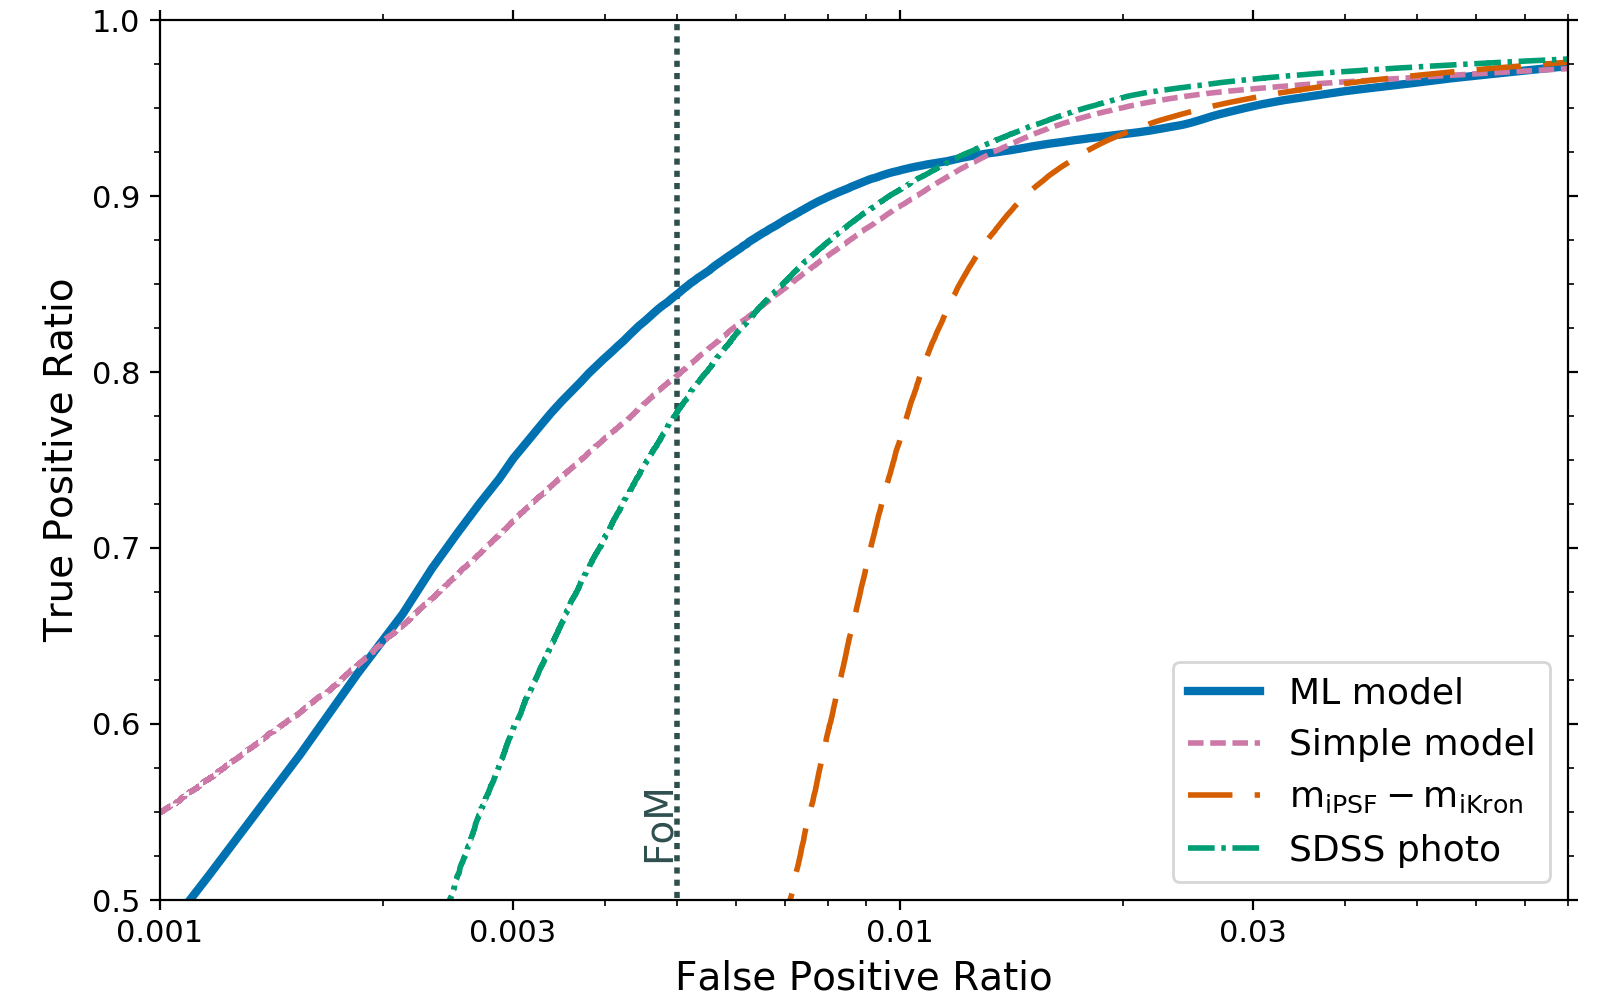

In [128]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# apple colors
color_dict = {'ml': "#0072c6", #"#1C1858",
              'sdss': "#5BC236", #"#00C78E",
              'simple': "#C864AF", #"#C70039",
              'ps1': "#C65400"}

# color blind friendly
color_dict = {'ml': '#0072b2', 
              'sdss': '#009e73', 
              'simple': '#cc79a7',
              'ps1': '#d55e00'}

fig, ax = plt.subplots(figsize=(8, 5))

ax.tick_params(which="both", top=True, right=True)

ax.plot(ml_fpr, ml_tpr, 
        color=color_dict['ml'], label='ML model', lw=3)
ax.plot(simple_fpr, simple_tpr,
        ls = '--', lw=2,
        color=color_dict['simple'], label='Simple model')
ax.plot(ps1_fpr, ps1_tpr,
        ls = '--', lw=2, dashes=(8, 4),
        color=color_dict['ps1'], label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
ax.plot(sdss_fpr, sdss_tpr,
        ls = '-.', lw=2,
        color=color_dict['sdss'], label='SDSS photo')
# ax.plot(sdss_fpr[np.argmin(np.abs(sdss_thresh-10**(-0.185/2.5)))], 
#         sdss_tpr[np.argmin(np.abs(sdss_thresh-10**(-0.185/2.5)))], '*', color="black")
ax.vlines([5e-3], 1e-3, 1, 
          linestyles=":", 
          color='DarkSlateGrey', lw=2)
ax.text(5e-3, 0.55, 'FoM', 
        color='DarkSlateGrey', 
        rotation=90, ha="right", fontsize=14)

ax.set_ylim(0.5, 1)
ax.set_xlim(1e-3, 8e-2)
ax.set_xscale("log")
ax.tick_params(labelsize = 11)
ax.set_xlabel('False Positive Ratio', fontsize=14)
ax.set_ylabel('True Positive Ratio', fontsize=14)

ax.set_xticks([1e-3, 3e-3, 1e-2, 3e-2])
ax.set_xticklabels([1e-3, 3e-3, 1e-2, 3e-2])
ax.yaxis.set_minor_locator(MultipleLocator(0.025))

ax.legend(loc=4, fontsize=13)

fig.subplots_adjust(top=0.98,right=0.98,left=0.1,bottom=0.1)
# fig.savefig('~/Desktop/ROC_sdss_spec.png')
# fig.savefig('ROC_sdss_spec.pdf')

Using the SDSS spectroscopic sample as a test set it is clear that the ML model provides the best FoM. However, at $\mathrm{FPR} \approx 0.015$ each of the 3 other models cross over the ML model ROC curve and provide a better performance. This is coupled with an unusual kink at $\mathrm{FPR} \approx 0.025$ that suggests something unusual is going on.

## Accuracy as a Function of Magnitude

We further explore the kink in the ROC curve by examining the accuracy as a function of magnitude. 

In [189]:
ml_decision_thresh = 0.5
sdss_decision_thresh = 10**(-0.185/2.5)
simple_decision_thresh = 9.2e-07 #  maximize acc on training set
ps1_decision_thresh = 0.05

ml_labels = np.logical_not(sdss_preds[:,1] < ml_decision_thresh).astype(int)
sdss_labels = np.logical_not(sdss_tbl["countRatio"].ix[sdss_test_set] < sdss_decision_thresh).astype(int)
simple_labels = np.logical_not(sdss_tbl["wwPSFKronDist"].ix[sdss_test_set] < simple_decision_thresh).astype(int)
ps1_labels = np.logical_not(-1*sdss_tbl["iPSFminusKron"].ix[sdss_test_set] < ps1_decision_thresh).astype(int)

In [184]:
binwidth = 0.5
Nboot = 100
mag_array = np.arange(13 , 23+binwidth, binwidth)
kron_mag = np.array(-2.5*np.log10(sdss_tbl['wwKronFlux'].ix[sdss_test_set]/3631))
sdss_acc_arr = np.zeros_like(mag_array)
simple_acc_arr = np.zeros_like(mag_array)
ps1_acc_arr = np.zeros_like(mag_array)
ml_acc_arr = np.zeros_like(mag_array)

sdss_boot_scatt = np.zeros_like(mag_array)
simple_boot_scatt = np.zeros_like(mag_array)
ps1_boot_scatt = np.zeros_like(mag_array)
ml_boot_scatt = np.zeros_like(mag_array)

for bin_num, binedge in enumerate(mag_array):
    bin_sources = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth))
    sdss_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_sources], 
                                           sdss_labels[bin_sources])
    simple_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_sources], 
                                             simple_labels[bin_sources])
    ps1_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_sources], 
                                          ps1_labels[bin_sources])
    ml_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_sources], 
                                         ml_labels[bin_sources])
    sdss_boot_acc = np.empty(Nboot)
    simple_boot_scatt = np.empty_like(sdss_boot_acc)
    ps1_boot_scatt = np.empty_like(sdss_boot_acc)
    ml_boot_scatt = np.empty_like(sdss_boot_acc)
    for i in range(Nboot):
        boot_sources = np.random.choice(bin_sources, len(bin_sources))
        sdss_boot_scatt[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                           sdss_labels[boot_sources])
        simple_boot_scatt[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                             simple_labels[boot_sources])
        ps1_boot_scatt[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                          ps1_labels[boot_sources])
        ml_boot_scatt[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                         ml_labels[boot_sources])

    sdss_boot_scatt[bin_num] = np.std(sdss_boot_acc)
    simple_boot_scatt[bin_num] = np.std(simple_boot_acc)
    ps1_boot_scatt[bin_num] = np.std(ps1_boot_acc)
    ml_boot_scatt[bin_num] = np.std(ml_boot_acc)


ValueError: Can only tuple-index with a MultiIndex

In [193]:
type(sdss_labels)

pandas.core.series.Series

In [187]:
sdss_labels[bin_sources[0]]

253        0.0
275        0.0
303        0.0
352        0.0
2693       NaN
2703       0.0
2835       0.0
3813       0.0
3843       0.0
3846       0.0
3847       0.0
3849       0.0
3853       0.0
3857       0.0
3952       0.0
3969       0.0
4087       0.0
4364       0.0
5981       NaN
6067       NaN
6076       NaN
6388       0.0
6406       0.0
6484       0.0
6888       0.0
8024       0.0
8142       0.0
8192       0.0
8446       0.0
8565       0.0
          ... 
3246095    0.0
3248949    1.0
3250478    1.0
3277993    0.0
3297848    0.0
3325364    1.0
3468867    1.0
3486096    0.0
3524305    1.0
3524306    1.0
3524307    1.0
3524440    1.0
3524447    1.0
3524935    0.0
3525053    1.0
3525282    1.0
3525611    0.0
3528468    0.0
3532566    1.0
3533290    1.0
3534296    0.0
3535949    0.0
3536766    0.0
3537228    0.0
3539043    1.0
3540731    1.0
3541594    1.0
3542487    1.0
3570753    0.0
3576838    0.0
Name: countRatio, dtype: float64